In [2]:
## https://www.kaggle.com/code/chiragksharma/imdb-sentiment-analysis-lstm-eda-95-acc

In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from bs4 import BeautifulSoup
import re, string,unicodedata


In [7]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 21.1 MB/s eta 0:00:00


In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
import transformers
import tokenizers

Data preprocessing


In [13]:
df = pd.read_csv('/content/IMDB Dataset 50k.csv')

In [14]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
df.shape

(50000, 2)

In [16]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

In [17]:
#finding the duplicates in the data
num_duplicates = df.duplicated().sum()


In [18]:
num_duplicates


418

In [19]:

print(f'the number of duplicates in the data', format(num_duplicates))

the number of duplicates in the data 418


In [20]:
review = df['review']
duplicate_review = df[review.isin(review[review.duplicated()])].sort_values('review')

In [21]:
duplicate_review.head()

,review,sentiment
34058,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
47467,"""Go Fish"" garnered Rose Troche rightly or wron...",negative
29956,"""Three"" is a seriously dumb shipwreck movie. M...",negative
31488,"""Three"" is a seriously dumb shipwreck movie. M...",negative
47527,"""Witchery"" might just be the most incoherent a...",negative


In [22]:
# dropping the duplicate values

df.drop_duplicates(inplace=True)

In [23]:
# Converting the text values of sentiments into numbers 
from sklearn import preprocessing


In [24]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
df['sentiment'] = label_encoder.fit_transform(df['sentiment'])

Cleaning the data

In [27]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
 stop = stopwords.words('english')
 wl = WordNetLemmatizer

In [29]:
#function to clean data
from bs4 import BeautifulSoup
import re,string,unicodedata
def clean_text(text,lemmatize = True):
    soup = BeautifulSoup(text, "html.parser") #remove html tags
    text = soup.get_text()
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")]) #expanding chatwords and contracts clearing contractions
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_clean.sub(r'',text)
    text = re.sub(r'\.(?=\S)', '. ',text) #add space after full stop
    text = re.sub(r'http\S+', '', text) #remove urls
    text = "".join([word.lower() for word in text if word not in string.punctuation]) #remove punctuation
    #tokens = re.split('\W+', text) #create tokens
    if lemmatize:
        text = " ".join([wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()]) #lemmatize
    else:
        text = " ".join([word for word in text.split() if word not in stop and word.isalpha()]) 
    return text

In [30]:
data_copy = df.copy()

In [31]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [32]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> l

Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] bcp47............... BCP-47 Language Tags
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [ ] cess_esp

True

In [33]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/


unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


In [34]:
df['review'] = df['review'].apply(clean_text, lemmatize=True)

NameError: ignored

In [35]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Data analysis


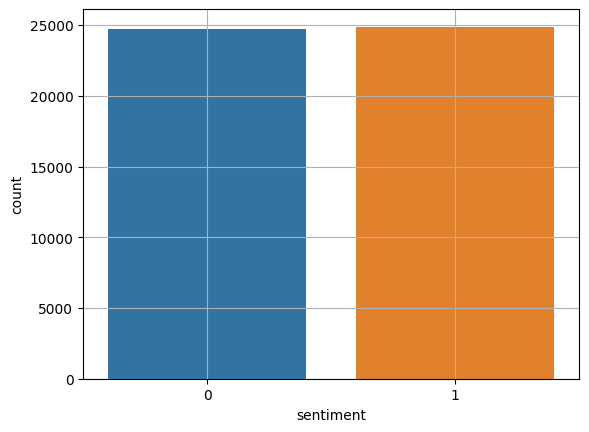

In [36]:
sns.countplot(x=df['sentiment'])
plt.grid()

In [37]:
print(f"There are about",df['sentiment'].value_counts()[0],"Positive reviews i.e.", round((df["sentiment"].value_counts()[0]/len(df["sentiment"])) * 100,2), "% of the dataset")
print(f"There are about",df['sentiment'].value_counts()[1],"Negative reviews i.e.", round((df["sentiment"].value_counts()[1]/len(df["sentiment"]))*100,2),"% of the dataset")

There are about 24698 Positive reviews i.e. 49.81 % of the dataset
There are about 24884 Negative reviews i.e. 50.19 % of the dataset


In [38]:
from wordcloud import WordCloud

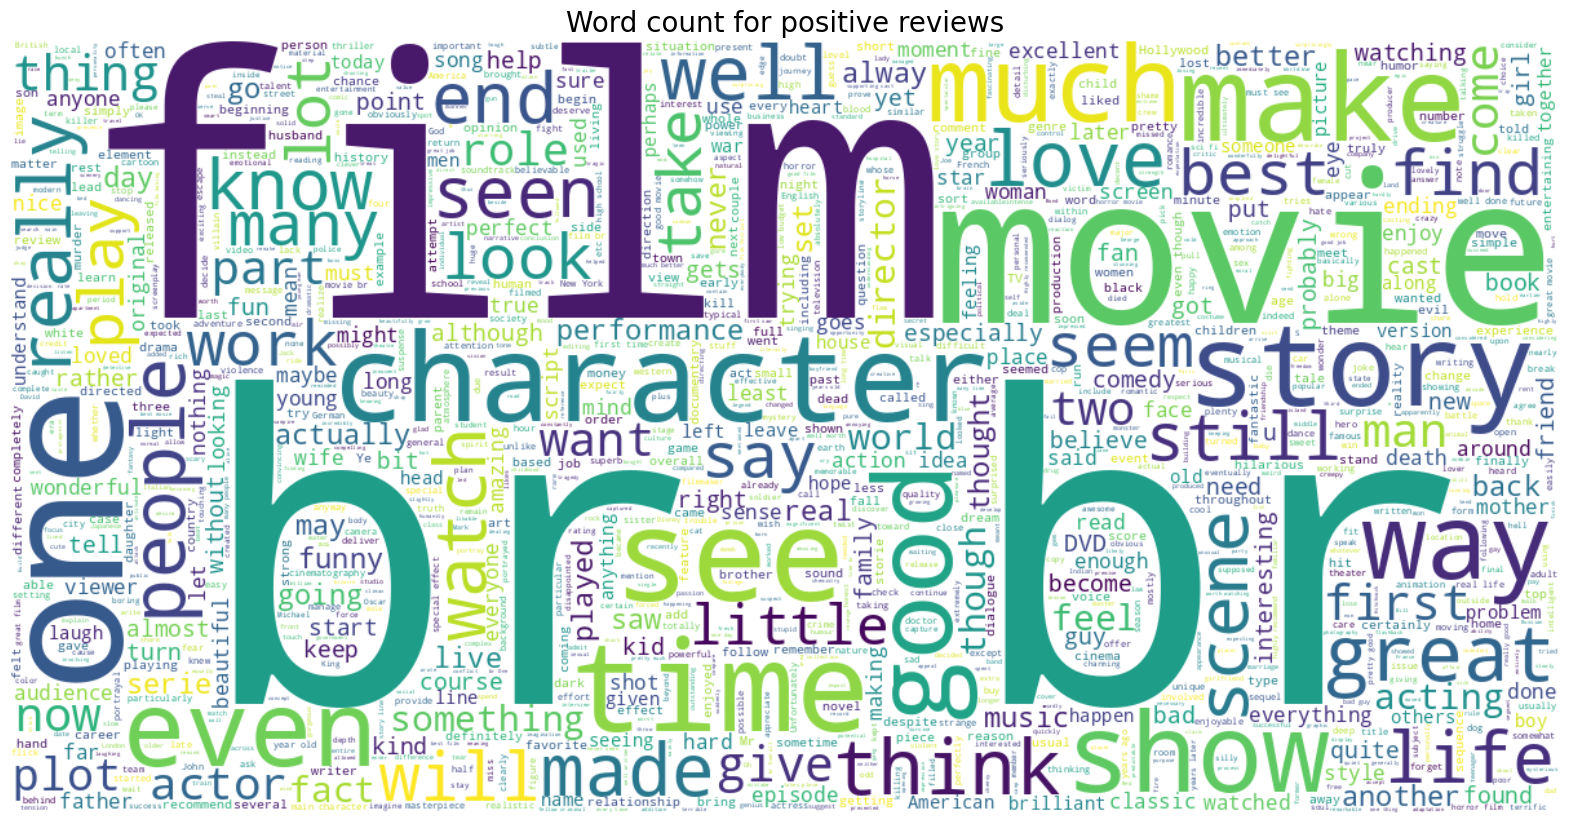

In [39]:
positive_review = df[df.sentiment == 1]["review"]
positive_review_string = ' '.join(positive_review)
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1200,width = 1200, height=600,background_color= "white").generate(positive_review_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.title("Word count for positive reviews",fontsize=20)
plt.show()

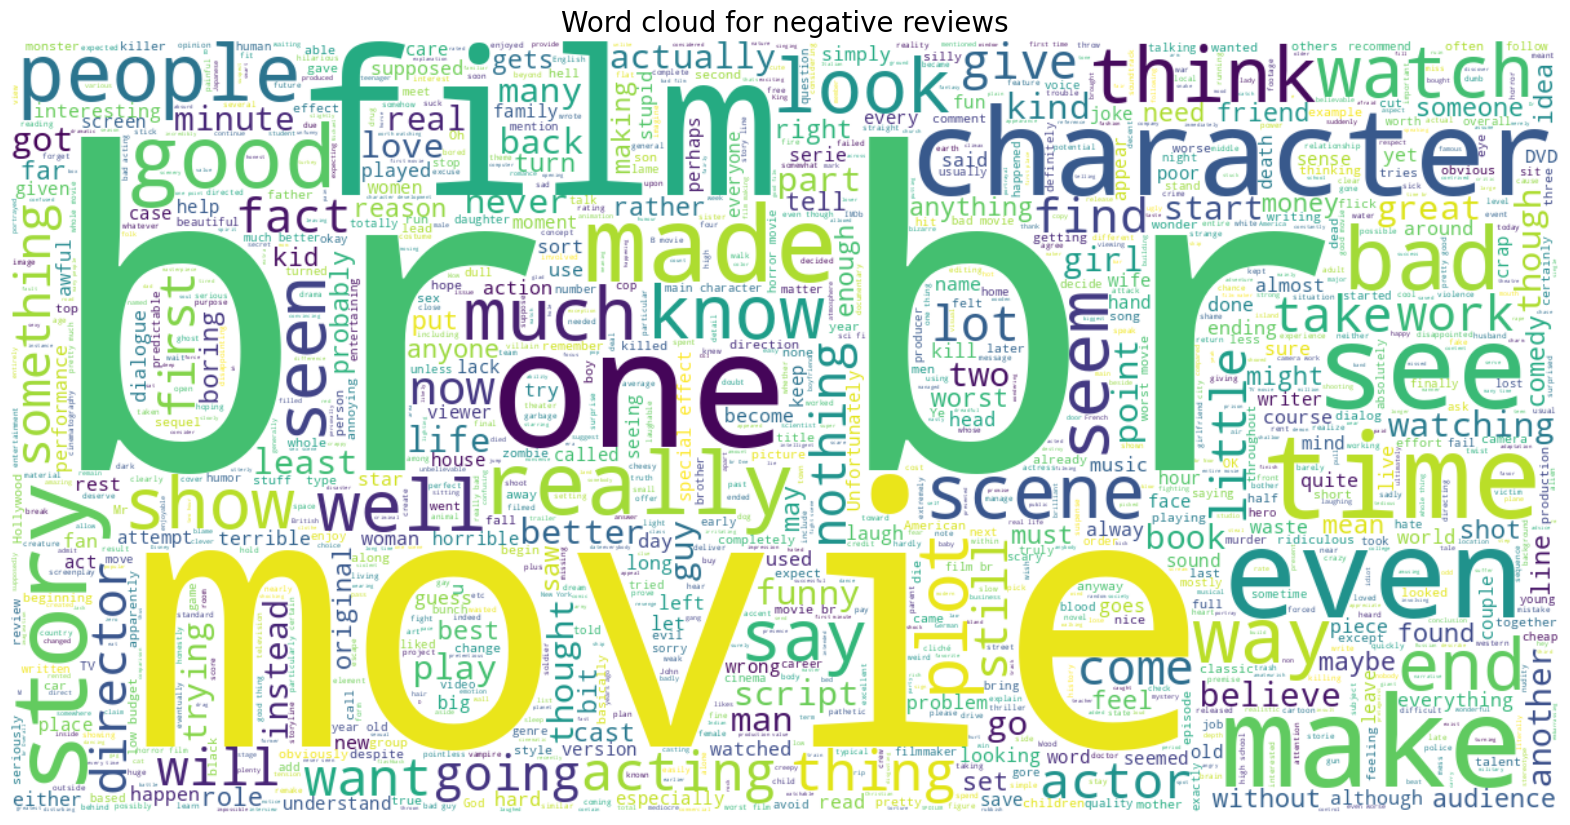

In [40]:
negative_data = df[df.sentiment == 0]["review"]
negative_data_string = ' '.join(negative_data)
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1200,width = 1200, height=600,background_color= "white").generate(negative_data_string)
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.title("Word cloud for negative reviews",fontsize=20)
plt.show()

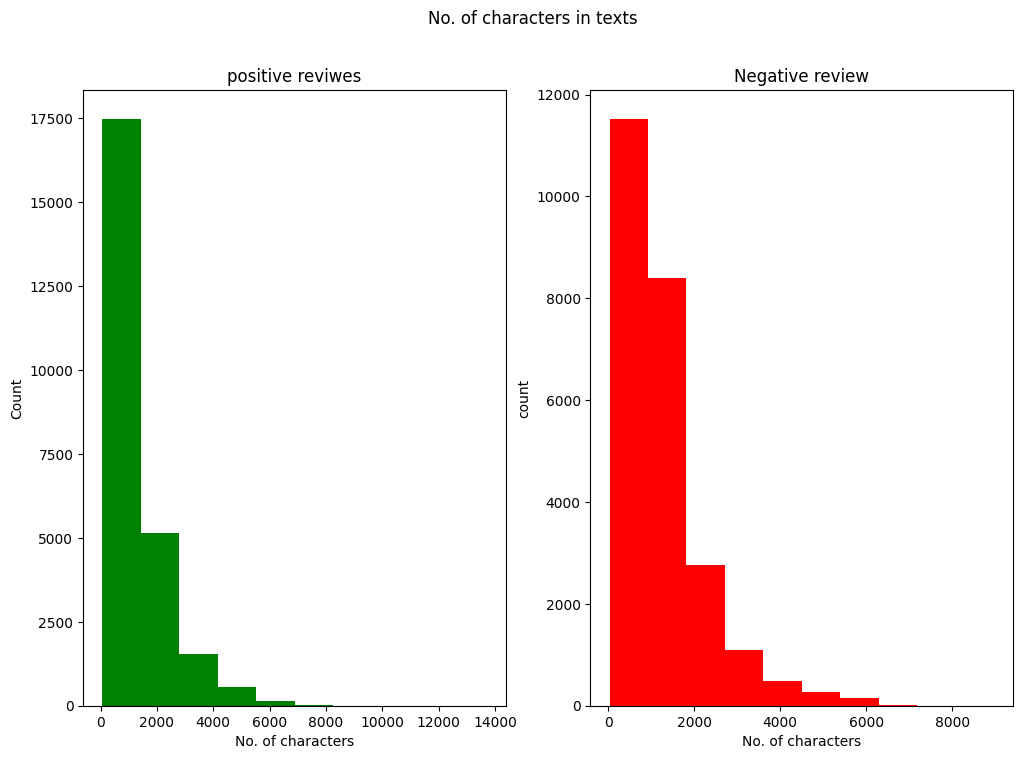

In [41]:
fig,(ax1,ax2) =plt.subplots(1,2,figsize=(12,8))
text_len = positive_review.str.len()
ax1.hist(text_len,color='green')
ax1.set_title("positive reviwes")
ax1.set_xlabel("No. of characters")
ax1.set_ylabel("Count")
text_len = negative_data.str.len()
ax2.hist(text_len,color="red")
ax2.set_title("Negative review")
ax2.set_xlabel("No. of characters")
ax2.set_ylabel("count")
fig.suptitle("No. of characters in texts")
plt.show()

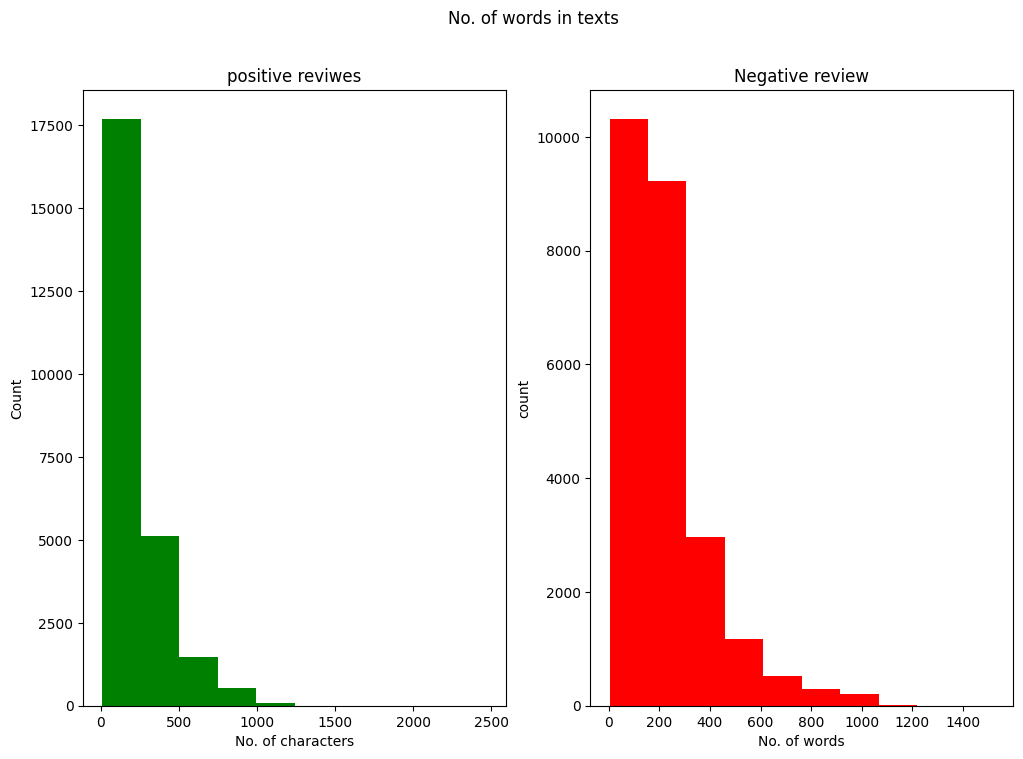

In [42]:
fig,(ax1,ax2) =plt.subplots(1,2,figsize=(12,8))
text_len = positive_review.str.split().map(lambda x: len(x))
ax1.hist(text_len,color='green')
ax1.set_title("positive reviwes")
ax1.set_xlabel("No. of characters")
ax1.set_ylabel("Count")
text_len = negative_data.str.split().map(lambda x: len(x))
ax2.hist(text_len,color="red")
ax2.set_title("Negative review")
ax2.set_xlabel("No. of words")
ax2.set_ylabel("count")
fig.suptitle("No. of words in texts")
plt.show()

In [43]:
def get_corpus(data):
    corpus = []
    for i in data:
        for j in i.split():
            corpus.append(j.strip())
    return corpus
corpus = get_corpus(df.review)
corpus[:5]


['One', 'of', 'the', 'other', 'reviewers']

In [44]:
from collections import Counter
count = Counter(corpus)
most_words = count.most_common(10)
most_common = pd.DataFrame(most_words,columns=["words","count_"])
most_common

,words,count_
0,the,563822
1,a,304532
2,and,299496
3,of,281335
4,to,259595
5,is,201455
6,in,168566
7,I,131237
8,that,125723
9,this,112701


In [45]:
# Sorting 
most_common= most_common.sort_values('count_')

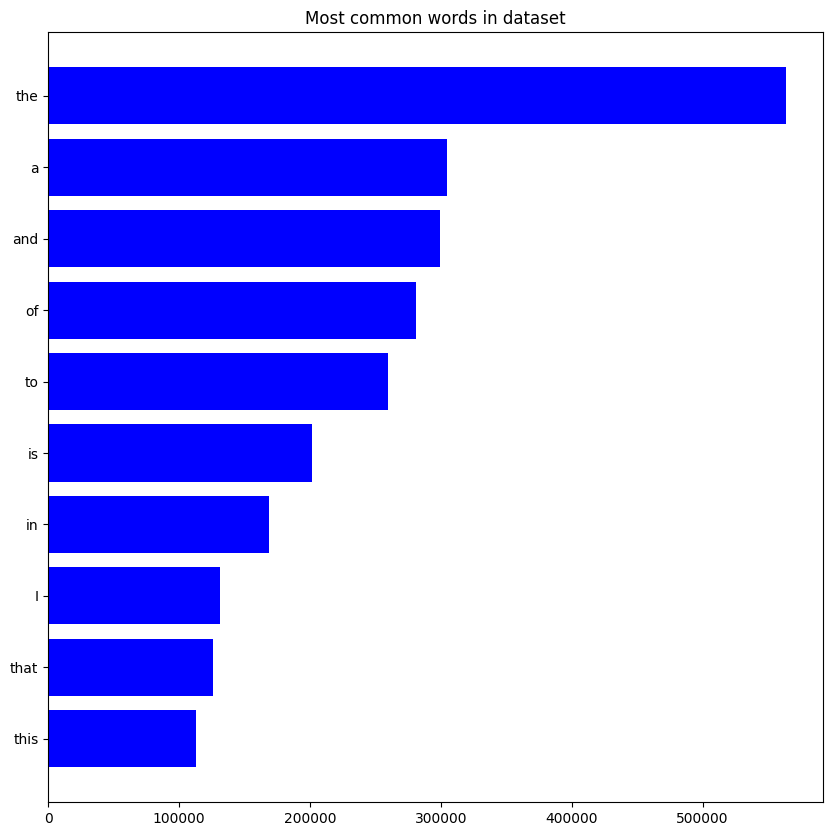

In [46]:
plt.figure(figsize=(10,10))
plt.yticks(range(len(most_common)),list(most_common.words))
plt.barh(range(len(most_common)),list(most_common.count_),align='center',color = 'blue')
plt.title("Most common words in dataset")
plt.show()

Text preprocessing


1. Convert in text reviews into lowercase


In [47]:
def convert_lowercase(column):
    column = column.str.lower()
    return column


In [48]:
print(f"Before applying lower casing: {df['review'][0][:10]}")


Before applying lower casing: One of the


In [49]:
df['review'] = convert_lowercase(df['review'])

print(f"After applying lower casing : {df['review'][0][:10]}")

After applying lower casing : one of the


Removing the HTML tags


In [50]:
import re
def remove_html_tags(text):
    re_html = re.compile('<.*?>')
    return re_html.sub(r'', text)

In [51]:
text = '<h1> This is a h1 tag </h1>'
print(remove_html_tags(text))

 This is a h1 tag 


In [52]:
print(f"Before removing HTML tags: {df['review'][1][:70]}")
df['review'] = df['review'].apply(remove_html_tags)
print(f"After removing HTML tags : {df['review'][1][:70]}")


Before removing HTML tags: a wonderful little production. <br /><br />the filming technique is ve
After removing HTML tags : a wonderful little production. the filming technique is very unassumin


Removing URL's


In [53]:
text = 'My profile link: https://www.kaggle.com/anubhavgoyal10'
def remove_url(text):
    re_url = re.compile('https?://\S+|www\.\S+')
    return re_url.sub('', text)

In [54]:
print(f'Text before removing URL: {text}')
print(f'Text after removing URL : {remove_url(text)}')


Text before removing URL: My profile link: https://www.kaggle.com/anubhavgoyal10
Text after removing URL : My profile link: 


In [55]:
from sklearn.model_selection import train_test_split
train_text, test_text, train_labels, test_labels = train_test_split(df["review"],df["sentiment"], test_size=0.33)

In [56]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Creates and fits a TensorFlow Tokenizer
tokenizer = Tokenizer(num_words=10_000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_text)

#Creates sequences of numeric representations of words
training_sequences = tokenizer.texts_to_sequences(train_text)
#pads sequences so they all have the same length
training_sequences = pad_sequences(training_sequences, maxlen=20)

#Process test data in the same way for later evaluation
testing_sequences = tokenizer.texts_to_sequences(test_text)
testing_sequences = pad_sequences(testing_sequences, maxlen=20)

        
#prints a sample of the new sequences
print('PROCESSED TEXT DATA')
print('=========================')
for i in range(5):
    print(training_sequences[i], '\n')

PROCESSED TEXT DATA
[  20   91 8524    1    2  145   16    1    2 6542   18 2985  188   21
   30   29    1    6    2  574] 

[  39  149  157    1 4853  357  250   18   58  213  436    8    2 1307
    2  143  324    7    2  247] 

[2335    5 1989  137   14   75    9   20    3    2    1  524  524 1167
  691  401   42    5  691 7635] 

[   2 2566   28   20   11   10  236  165    6  866   53    4  334 4451
    3  642   22    4    1    1] 

[1121 1390   44   21   37  221    4  112  272 4452   33  142  275    4
    1  824 1812   20   11   19] 



In [57]:
train_labels.reset_index(inplace=True, drop=True)


Custom Callback


In [58]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("Accuracy over 95%... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

Pre defined Callbacks


In [59]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)


In [60]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam

#input dimensions is equal to number of words tokenized (defined above)
input_dim = 10_000
# input length will be the length of our padded sequences
input_length = 20


#defines a text classifier model
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=64, input_length=input_length),
    Bidirectional(LSTM(150)),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              258000    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 512)               154112    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [61]:
from sklearn import preprocessing
  
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
df['sentiment']= label_encoder.fit_transform(df['sentiment'])

In [62]:
history = model.fit(
    np.array(training_sequences), #must convert to numpy array before sending to model
    np.array(train_labels),       #must convert to numpy array before sending to model
    epochs=100, 
    batch_size=128,                
    callbacks=[my_callback, lr_scheduler],verbose=1)

Epoch 1/100
260/260 [==============================] - 54s 179ms/step - loss: 0.5291 - accuracy: 0.7270 - lr: 0.0100
Epoch 2/100
260/260 [==============================] - 47s 182ms/step - loss: 0.4087 - accuracy: 0.8156 - lr: 0.0100
Epoch 3/100
260/260 [==============================] - 59s 228ms/step - loss: 0.3041 - accuracy: 0.8679 - lr: 0.0099
Epoch 4/100
260/260 [==============================] - 56s 215ms/step - loss: 0.2240 - accuracy: 0.9055 - lr: 0.0098
Epoch 5/100
260/260 [==============================] - 48s 185ms/step - loss: 0.1690 - accuracy: 0.9329 - lr: 0.0097
Epoch 6/100
260/260 [==============================] - 49s 187ms/step - loss: 0.1300 - accuracy: 0.9487 - lr: 0.0096
Epoch 7/100
260/260 [==============================] - 48s 183ms/step - loss: 0.1061 - accuracy: 0.9596 - lr: 0.0095


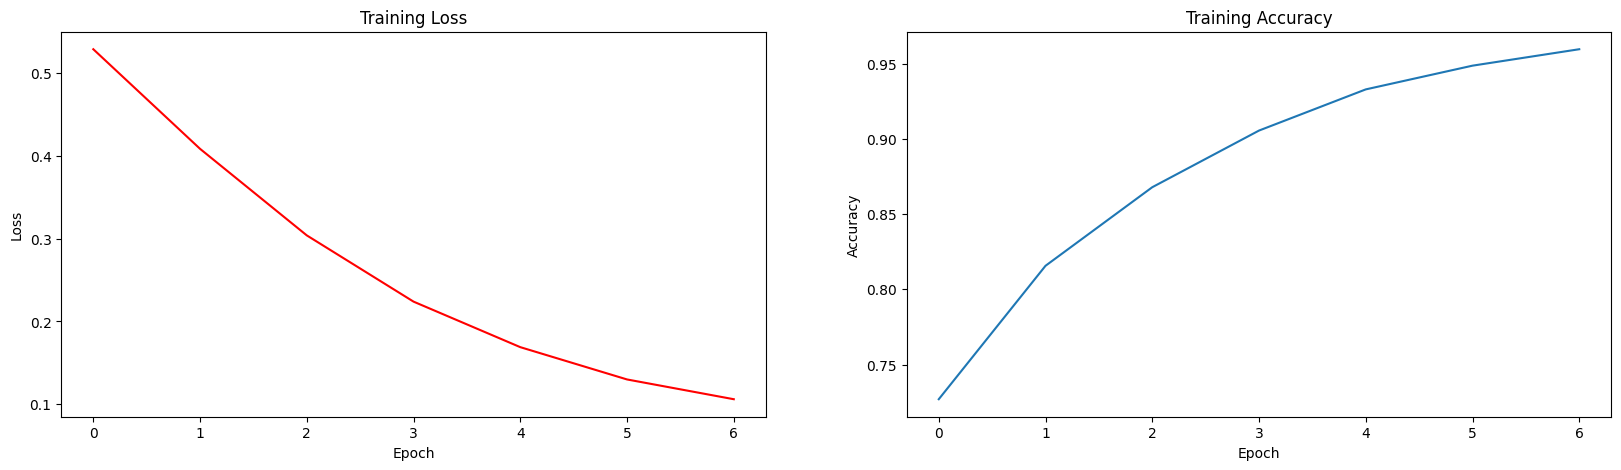

In [64]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy')

plt.show()


In [65]:
NEW_REVIEW =\
"""
This movie was garbage. I wish I never came to the theater to watch it.
"""


In [66]:
#Process the new review the same way the test text was processed
new_review_sequence = tokenizer.texts_to_sequences([NEW_REVIEW])
new_review_sequence = pad_sequences(new_review_sequence, maxlen=20)

#sends new review to be predicted by the model
new_review_prediction = round(model.predict(np.array(new_review_sequence))[0][0])
sentiment = "NEGATIVE" if new_review_prediction == 0 else "POSITIVE"

#displays what the model thinks the sentiment of the review was
print("MOVIE REVIEW:", NEW_REVIEW)
print("MODEL PREDICTED SENTIMENT:", sentiment)

1/1 [==============================] - 1s 879ms/step
MOVIE REVIEW: 
This movie was garbage. I wish I never came to the theater to watch it.

MODEL PREDICTED SENTIMENT: NEGATIVE


In [67]:
model.save('imdb_model.h5')